In [63]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [64]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
trainset, valset = random_split(dataset, [30000, 20000])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'{device} is available.')

cuda is available.


In [66]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channles, out_channels, stride=1) -> None:
        super().__init__()
        self.stride = stride
        self.in_channles = in_channles
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channles, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
        )

        if self.stride != 1 or self.in_channles != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channles, self.out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.out_channels)
            )

    def forward(self, x):
        out = self.conv_block(x)

        if self.stride != 1 or self.in_channles != self.out_channels:
            x = self.downsample(x)

        out = F.relu(x + out)

        return out


In [67]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10) -> None:
        super().__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.gap = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels

        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [68]:
def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])
    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])

In [69]:
resnet = modeltype('resnet18').to(device)

In [70]:
print(resnet)

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [71]:
PATH = 'models/cifar_resnet_early.pth'

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [73]:
def validation_loss(dataloader):
    running_loss = 0.0
    with torch.inference_mode():
        resnet.eval()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(dataloader)

In [74]:
train_loss_list = []
val_loss_list = []
early_stopping_loss = 1
for epoch in range(51):
    resnet.train()
    running_loss = 0.0
    for images, labels in trainloader:
        inputs, labels = images.to(device), labels.to(device)
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_loss_list.append(train_loss)
    val_loss = validation_loss(valloader)
    val_loss_list.append(val_loss)

    print(f'[{epoch + 1}] train loss: {train_loss:.3f}, validation_loss: {val_loss:.3f}')

    if val_loss < early_stopping_loss:
        torch.save(resnet.state_dict(), PATH)
        early_stopping_train_loss = train_loss
        early_stopping_val_loss = val_loss
        early_stopping_epoch = epoch

print(f'Final pretrained model >> [{early_stopping_epoch + 1}] train loss: {early_stopping_train_loss:.3f}, validation_loss: {early_stopping_val_loss:.3f}')

[1] train loss: 1.524, validation_loss: 1.242
[2] train loss: 1.037, validation_loss: 0.910
[3] train loss: 0.793, validation_loss: 0.783
[4] train loss: 0.631, validation_loss: 0.700
[5] train loss: 0.502, validation_loss: 0.654
[6] train loss: 0.398, validation_loss: 0.632
[7] train loss: 0.296, validation_loss: 0.695
[8] train loss: 0.218, validation_loss: 0.697
[9] train loss: 0.159, validation_loss: 0.830
[10] train loss: 0.114, validation_loss: 0.832
[11] train loss: 0.087, validation_loss: 0.821
[12] train loss: 0.080, validation_loss: 0.862
[13] train loss: 0.068, validation_loss: 0.935
[14] train loss: 0.072, validation_loss: 0.804
[15] train loss: 0.050, validation_loss: 0.949
[16] train loss: 0.059, validation_loss: 0.907
[17] train loss: 0.043, validation_loss: 1.017
[18] train loss: 0.054, validation_loss: 0.969
[19] train loss: 0.048, validation_loss: 0.968
[20] train loss: 0.026, validation_loss: 0.958
[21] train loss: 0.039, validation_loss: 0.968
[22] train loss: 0.038

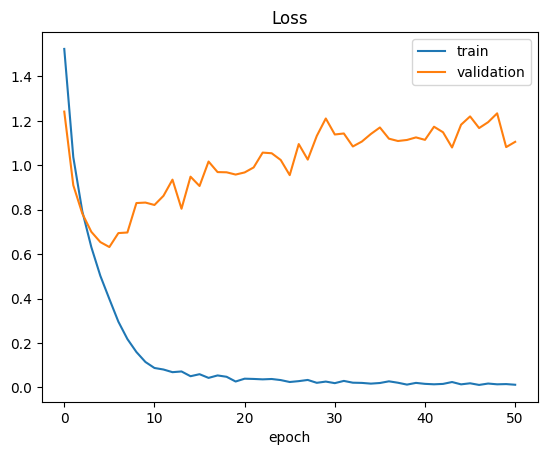

In [75]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
resnet = modeltype('resnet18').to(device)
resnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [77]:
correct = 0
total = 0
with torch.inference_mode():
    resnet.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        preds = outputs.argmax(axis=1)
        total += len(labels)
        correct += (preds == labels).sum().item()

print(f'Test accuracy: {100 * correct / total:.2f}')

Test accuracy: 81.37
